## 서울시 범죄 현황 분석

In [1]:
!pip install folium

In [2]:
import folium
folium.__version__

'0.12.1.post1'

In [3]:
import warnings
warnings.filterwarnings('ignore')

### 데이터 파악하고 정리하기

- 필요한 - 불러오기

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('font', family='AppleGothic')
mpl.rc('axes', unicode_minus=False)     # 한글 폰트 사용 시, 마이너스 글자가 깨지는 현상을 해결

In [46]:
crime = pd.read_csv('/Users/kimhansaem/workspace/01.MachineLearning/13.보강/data/서울시 5대범죄 발생현황(2019).tsv', sep='\t', skiprows=1, thousands=',')
crime.head(3)

,기간,자치구,발생,검거,발생.1,검거.1,발생.2,검거.2,발생.3,검거.3,발생.4,검거.4,발생.5,검거.5
0,2019,합계,103668,74805,136,128,136,133,6469,6007,42204,21284,54723,47253
1,2019,종로구,3846,4117,4,5,7,8,238,1143,1515,1069,2082,1892
2,2019,중구,4327,2804,2,1,6,5,195,115,2202,1050,1922,1633


In [47]:
crime.drop([0], inplace=True)       # 첫번째 행 삭제(합계행)
crime.drop(columns=['기간'], inplace=True)      # 기간 열 삭제
crime.head(3)

,자치구,발생,검거,발생.1,검거.1,발생.2,검거.2,발생.3,검거.3,발생.4,검거.4,발생.5,검거.5
1,종로구,3846,4117,4,5,7,8,238,1143,1515,1069,2082,1892
2,중구,4327,2804,2,1,6,5,195,115,2202,1050,1922,1633
3,용산구,3313,2611,3,3,3,4,272,237,999,544,2036,1823


In [48]:
crime.rename({
    '자치구':'구별', '발생.1':'살인발생', '검거.1':'살인검거',
    '발생.2':'강도발생', '검거.2':'강도검거',
    '발생.3':'강간발생', '검거.3':'강간검거',
    '발생.4':'절도발생', '검거.4':'절도검거',
    '발생.5':'폭력발생', '검거.5':'폭력검거'
}, inplace=True, axis=1)
crime.head(3)

,구별,발생,검거,살인발생,살인검거,강도발생,강도검거,강간발생,강간검거,절도발생,절도검거,폭력발생,폭력검거
1,종로구,3846,4117,4,5,7,8,238,1143,1515,1069,2082,1892
2,중구,4327,2804,2,1,6,5,195,115,2202,1050,1922,1633
3,용산구,3313,2611,3,3,3,4,272,237,999,544,2036,1823


In [49]:
crime['살인검거율'] = np.round(crime['살인검거']/crime['살인발생']*100,2)
crime['강도검거율'] = np.round(crime['강도검거']/crime['강도발생']*100,2)
crime['강간검거율'] = np.round(crime['강간검거']/crime['강간발생']*100,2)
crime['절도검거율'] = np.round(crime['절도검거']/crime['절도발생']*100,2)
crime['폭력검거율'] = np.round(crime['폭력검거']/crime['폭력발생']*100,2)
crime.drop(columns=['발생', '검거', '살인검거', '강도검거', '강간검거', '절도검거', '폭력검거'],
            inplace=True)
crime.head(3)

,구별,살인발생,강도발생,강간발생,절도발생,폭력발생,살인검거율,강도검거율,강간검거율,절도검거율,폭력검거율
1,종로구,4,7,238,1515,2082,125.0,114.29,480.25,70.56,90.87
2,중구,2,6,195,2202,1922,50.0,83.33,58.97,47.68,84.96
3,용산구,3,3,272,999,2036,100.0,133.33,87.13,54.45,89.54


In [50]:
# 검거율이 100을 넘으면 100으로 처리
col_list = '살인검거율	강도검거율	강간검거율	절도검거율	폭력검거율'.split()
for col in col_list:
#    for i in crime.index:
#        crime[col][i] = 100. if crime[col][i] > 100. else crime[col][i]
    crime.loc[crime[col] > 100., col] = 100.
crime.head(3)

,구별,살인발생,강도발생,강간발생,절도발생,폭력발생,살인검거율,강도검거율,강간검거율,절도검거율,폭력검거율
1,종로구,4,7,238,1515,2082,100.0,100.00,100.00,70.56,90.87
2,중구,2,6,195,2202,1922,50.0,83.33,58.97,47.68,84.96
3,용산구,3,3,272,999,2036,100.0,100.00,87.13,54.45,89.54


- 발생 데이터 0~1사이의 값으로 정규화

In [51]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x = scaler.fit_transform(crime['살인발생'].values.reshape(-1,1))
x[:,0]

array([0.25      , 0.08333333, 0.16666667, 0.41666667, 0.25      ,
       0.41666667, 0.75      , 0.16666667, 0.41666667, 0.        ,
       0.25      , 0.16666667, 0.08333333, 0.08333333, 0.41666667,
       0.58333333, 0.75      , 0.41666667, 0.75      , 0.25      ,
       1.        , 0.33333333, 0.33333333, 0.5       , 0.41666667])

In [52]:
for col in '살인발생	강도발생	강간발생	절도발생	폭력발생'.split():
    result = scaler.fit_transform(crime[col].values.reshape(-1,1))
    crime[col] = np.round(result[:,0], 2)
crime.head(3)

,구별,살인발생,강도발생,강간발생,절도발생,폭력발생,살인검거율,강도검거율,강간검거율,절도검거율,폭력검거율
1,종로구,0.25,0.43,0.26,0.33,0.35,100.0,100.00,100.00,70.56,90.87
2,중구,0.08,0.36,0.18,0.65,0.29,50.0,83.33,58.97,47.68,84.96
3,용산구,0.17,0.14,0.32,0.10,0.33,100.0,100.00,87.13,54.45,89.54


In [53]:
df = pd.read_csv('/Users/kimhansaem/workspace/01.MachineLearning/13.보강/data/서울시_CCTV_인구_병합데이터2.csv')
df.head()

,구별,CCTV댓수,최근증가율,인구수,외국인,고령자,외국인비율,고령자비율
0,종로구,1772,20.49,155106,9077,27605,5.85,17.80
1,중구,2333,78.98,132259,9243,23980,6.99,18.13
2,용산구,2383,78.64,240665,14287,38884,5.94,16.16
3,성동구,3602,46.13,295767,6605,45591,2.23,15.41
4,광진구,2588,112.29,355306,12825,50815,3.61,14.30


- 서울시 인구/CCTV 데이터와 범죄 발생 현황 데이터 병합

In [54]:
cdf = pd.merge(crime, df[['구별','CCTV댓수','인구수']])
cdf.head(3)

,구별,살인발생,강도발생,강간발생,절도발생,폭력발생,살인검거율,강도검거율,강간검거율,절도검거율,폭력검거율,CCTV댓수,인구수
0,종로구,0.25,0.43,0.26,0.33,0.35,100.0,100.00,100.00,70.56,90.87,1772,155106
1,중구,0.08,0.36,0.18,0.65,0.29,50.0,83.33,58.97,47.68,84.96,2333,132259
2,용산구,0.17,0.14,0.32,0.10,0.33,100.0,100.00,87.13,54.45,89.54,2383,240665


In [55]:
cdf['범죄'] = np.sum(cdf.values[:,1:6], axis=1)
cdf['검거'] = np.sum(cdf.values[:,6:11], axis=1)

cdf.head(3)

,구별,살인발생,강도발생,강간발생,절도발생,폭력발생,살인검거율,강도검거율,강간검거율,절도검거율,폭력검거율,CCTV댓수,인구수,범죄,검거
0,종로구,0.25,0.43,0.26,0.33,0.35,100.0,100.00,100.00,70.56,90.87,1772,155106,1.62,461.43
1,중구,0.08,0.36,0.18,0.65,0.29,50.0,83.33,58.97,47.68,84.96,2333,132259,1.56,324.94
2,용산구,0.17,0.14,0.32,0.10,0.33,100.0,100.00,87.13,54.45,89.54,2383,240665,1.06,431.12


- 시각화하기

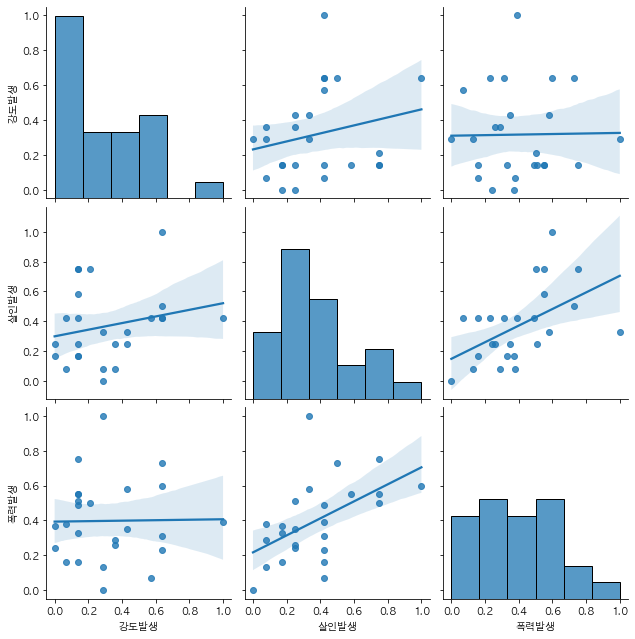

In [56]:
sns.pairplot(cdf, vars=['강도발생', '살인발생', '폭력발생'], kind='reg', size=3)

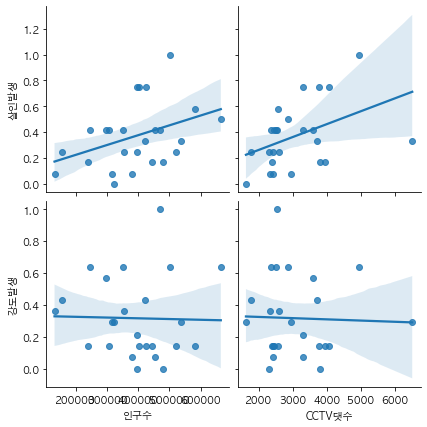

In [57]:
sns.pairplot(cdf, x_vars=['인구수', 'CCTV댓수'],
                y_vars=['살인발생','강도발생'], kind='reg', size=3);

In [58]:
# 히트맵
x = scaler.fit_transform(cdf['검거'].values.reshape(-1,1))
cdf['검거'] = np.round(x[:,0]*100, 2)
# cdf.set_index('구별', inplace=True) -> 이거 넣으면 cdf_sort.set_index('구별', inplace=True) 밑에서 이거 안해도 됨
cdf.head(3)

,구별,살인발생,강도발생,강간발생,절도발생,폭력발생,살인검거율,강도검거율,강간검거율,절도검거율,폭력검거율,CCTV댓수,인구수,범죄,검거
0,종로구,0.25,0.43,0.26,0.33,0.35,100.0,100.00,100.00,70.56,90.87,1772,155106,1.62,100.00
1,중구,0.08,0.36,0.18,0.65,0.29,50.0,83.33,58.97,47.68,84.96,2333,132259,1.56,3.37
2,용산구,0.17,0.14,0.32,0.10,0.33,100.0,100.00,87.13,54.45,89.54,2383,240665,1.06,78.54


In [59]:
cdf_sort = cdf.sort_values(by='검거', ascending=False)
cdf_sort.head(3)

,구별,살인발생,강도발생,강간발생,절도발생,폭력발생,살인검거율,강도검거율,강간검거율,절도검거율,폭력검거율,CCTV댓수,인구수,범죄,검거
0,종로구,0.25,0.43,0.26,0.33,0.35,100.0,100.0,100.00,70.56,90.87,1772,155106,1.62,100.00
11,은평구,0.17,0.00,0.18,0.36,0.37,100.0,100.0,83.51,62.43,87.72,3791,479409,1.08,80.34
7,성북구,0.17,0.14,0.15,0.13,0.16,100.0,100.0,73.86,67.56,90.27,3958,443206,0.75,78.95


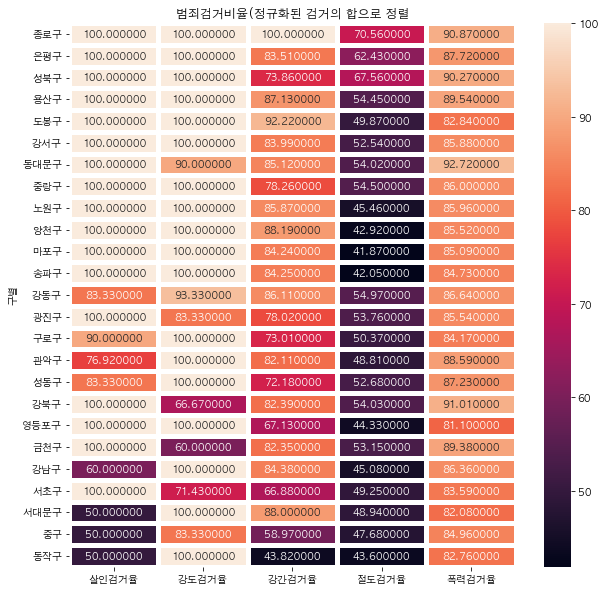

In [60]:
target_col = '살인검거율	강도검거율	강간검거율	절도검거율	폭력검거율'.split()
cdf_sort.set_index('구별', inplace=True)

plt.figure(figsize=(10,10))
sns.heatmap(cdf_sort[target_col], annot=True, fmt='f', linewidths=5)
plt.title('범죄검거비율(정규화된 검거의 합으로 정렬')
plt.show() 

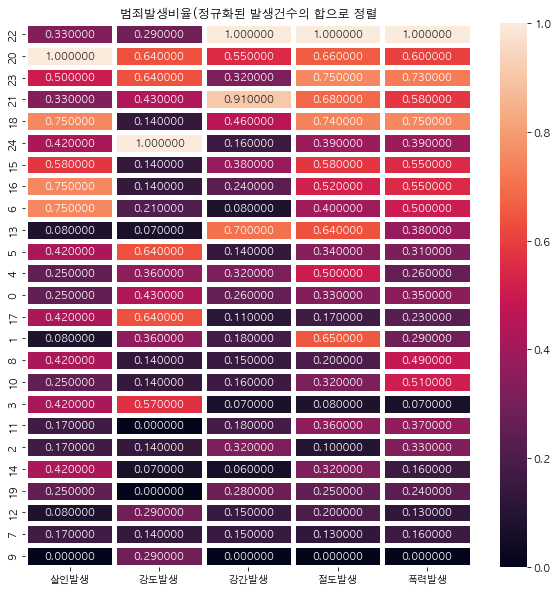

In [61]:
target_col = '살인발생	강도발생	강간발생	절도발생	폭력발생'.split()
cdf_sort = cdf.sort_values(by='범죄', ascending=False)

plt.figure(figsize=(10,10))
sns.heatmap(cdf_sort[target_col], annot=True, fmt='f', linewidths=5)
plt.title('범죄발생비율(정규화된 발생건수의 합으로 정렬')
plt.show()

In [62]:
cdf.set_index('구별', inplace=True)
cdf.head()

,살인발생,강도발생,강간발생,절도발생,폭력발생,살인검거율,강도검거율,강간검거율,절도검거율,폭력검거율,CCTV댓수,인구수,범죄,검거
구별,,,,,,,,,,,,,,
종로구,0.25,0.43,0.26,0.33,0.35,100.00,100.00,100.00,70.56,90.87,1772,155106,1.62,100.00
중구,0.08,0.36,0.18,0.65,0.29,50.00,83.33,58.97,47.68,84.96,2333,132259,1.56,3.37
용산구,0.17,0.14,0.32,0.10,0.33,100.00,100.00,87.13,54.45,89.54,2383,240665,1.06,78.54
성동구,0.42,0.57,0.07,0.08,0.07,83.33,100.00,72.18,52.68,87.23,3602,295767,1.21,53.27
광진구,0.25,0.36,0.32,0.50,0.26,100.00,83.33,78.02,53.76,85.54,2588,355306,1.69,56.97


In [63]:
cdf.to_csv('data/서울시_범죄_결과.csv')

### 지도 시각화

In [64]:
import json
geo_str = json.load(open('data/skorea_municipalities_geo_simple.json', encoding='utf8'))

In [71]:
map = folium.Map(location=[37.5502, 126.982], zoom_start=11,
                    tiles='Stamen Toner')
# choropleth : 단계 구분도
map.choropleth(
    geo_data=geo_str, 
    data=cdf['살인발생'],
    columns=[cdf.index, cdf.살인발생],
    fill_color='PuRd',
    key_on='feature.id' 
    #feature_id:id 값과 서울시 cctc결과에 있는 구별 index가 같으면 같이 맵핑해서 지도 그리라는 의미
)
title = '<h3 align="center" style="font-size:20px">서울시 구별 살인발생 비율</h3>'
map.get_root().html.add_child(folium.Element(title))
map

In [73]:
map = folium.Map(location=[37.5502, 126.982], zoom_start=11,
                    tiles='Stamen Toner')
# choropleth : 단계 구분도
map.choropleth(
    geo_data=geo_str, 
    data=cdf['강간발생'],
    columns=[cdf.index, cdf.강간발생],
    fill_color='Reds',
    key_on='feature.id' 
    #feature_id:id 값과 서울시 cctc결과에 있는 구별 index가 같으면 같이 맵핑해서 지도 그리라는 의미
)
title = '<h3 align="center" style="font-size:20px">서울시 구별 강간발생 비율</h3>'
map.get_root().html.add_child(folium.Element(title))
map

In [76]:
map = folium.Map(location=[37.5502, 126.982], zoom_start=11) # default 값: open street map
# choropleth : 단계 구분도
map.choropleth(
    geo_data=geo_str, 
    data=cdf['검거'],
    columns=[cdf.index, cdf.검거],
    fill_color='YlGnBu',
    key_on='feature.id' 
    #feature_id:id 값과 서울시 cctc결과에 있는 구별 index가 같으면 같이 맵핑해서 지도 그리라는 의미
)
title = '<h3 align="center" style="font-size:20px">서울시 구별 검거 비율</h3>'
map.get_root().html.add_child(folium.Element(title))
map